In [2]:
import pandas as pd
import pickle
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from keras.utils import pad_sequences
from torch.nn.utils.rnn import pad_sequence
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Funkcje pomocnicze

In [15]:
class LSTMRegressorFeatures(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, out_size, num_features, max_length, hidden_layers=1, dropout=0.1, bidirectional=False):
        super(LSTMRegressorFeatures, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = 2 if bidirectional else 1

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, bidirectional=bidirectional, dropout=dropout)

        self.fc_in = nn.Linear(num_features, hidden_size)
        self.layers = nn.ModuleList(
            [nn.Sequential(
                nn.Linear(hidden_size, hidden_size),
                nn.BatchNorm1d(hidden_size),
                nn.Dropout(dropout)
            ) for _ in range(hidden_layers)]
        )

        self.fc_out = nn.Linear(hidden_size * self.bidirectional * max_length + hidden_size, out_size)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def init_hidden(self, batch_size):
        # Inicjalizacja stanów ukrytych
        hidden = torch.zeros(self.num_layers * self.bidirectional, batch_size, self.hidden_size)
        state = torch.zeros(self.num_layers * self.bidirectional, batch_size, self.hidden_size)
        return hidden, state

    def forward(self, x, hidden, features):
        x = x.transpose(0, 1)
        all_outputs, hidden = self.lstm(x, hidden)

        features = self.LeakyReLU(self.fc_in(features))
        for layer in self.layers:
            features = self.LeakyReLU(layer(features))

        all_outputs = all_outputs.transpose(0, 1)
        x = torch.cat((all_outputs.contiguous().view(all_outputs.size(0), -1), features), dim=1)
        x = self.fc_out(x)
        return x, hidden

In [5]:
def train_lstm_features(model, train_loader, val_loader, optimizer, loss_fn, eval_fn, n_epochs=100, verbose=True, device='cuda'):
    if verbose:
        rng = tqdm(range(n_epochs))
    else:
        rng = range(n_epochs)

    loss_hist = []
    train_eval_hist = []
    val_eval_hist = []

    for epoch in rng:
        for x, features, targets, _, _, _ in train_loader:
            x = x.to(device).unsqueeze(2)
            targets = targets.to(device)
            features = features.to(device)
            hidden, state = model.init_hidden(x.size(0))
            hidden, state = hidden.to(device), state.to(device)
            preds, _ = model(x, (hidden,state), features)
            targets = targets.squeeze()
            targets = targets.type(torch.LongTensor).to(device)
            optimizer.zero_grad()
            loss = loss_fn(preds, targets)
            loss.backward()
            optimizer.step()
        if epoch % 10 == 0 and verbose:
            print(f"Epoch: {epoch}, loss: {loss.item():.3}")

        loss_hist.append(loss.item())
        train_eval_hist.append(eval_fn(model, train_loader, device))
        val_eval_hist.append(eval_fn(model, val_loader, device))

    return loss_hist, train_eval_hist, val_eval_hist

In [25]:
def pad_collate_feat(batch, pad_value=-1):
    xx, ff, yy = zip(*batch)

    x_lens = []
    for x in xx:
        try:
            x_lens.append(len(x))
        except:
            print(x)
            raise
    f_lens = [len(f) for f in ff]
    y_lens = [1 for y in yy]

    xx_pad = pad_sequence(xx, batch_first=True, padding_value=pad_value)
    ff = torch.stack(ff)
    yy = torch.stack(yy)

    return xx_pad, ff, yy, x_lens, f_lens, y_lens

In [7]:
def get_accuracy_features(net, data_loader, device):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, f, y, _, _, _ in data_loader:
            x, f, y = x.to(device).unsqueeze(2), f.to(device), y.to(device)
            hidden, state = net.init_hidden(x.size(0))
            hidden, state = hidden.to(device), state.to(device)
            preds, _ = net(x, (hidden, state), f)
            _, predicted = torch.max(preds, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
    net.train()
    return correct / total

In [8]:
def get_confusion_matrix_features(net, data_loader, n_classes, device):
    net.eval()
    confusion_matrix = torch.zeros(n_classes, n_classes)
    with torch.no_grad():
        for x, f, y, _, _, _ in data_loader:
            x, f, y = x.to(device).unsqueeze(2), f.to(device), y.to(device)
            hidden, state = net.init_hidden(x.size(0))
            hidden, state = hidden.to(device), state.to(device)
            preds, _ = net(x, (hidden, state), f)
            _, predicted = torch.max(preds, 1)
            for t, p in zip(y.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
    net.train()
    return confusion_matrix

In [11]:
def plot_confusion_matrix(confusion_matrix, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    confusion_matrix = confusion_matrix.float() / confusion_matrix.sum(1).view(-1, 1)
    plt.figure(figsize=(10, 10))
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = confusion_matrix.max() / 2.
    for i in range(confusion_matrix.size(0)):
        for j in range(confusion_matrix.size(1)):
            plt.text(j, i, format(confusion_matrix[i, j], ".2f"),
                     ha="center", va="center",
                     color="white" if confusion_matrix[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

def plot_training(loss, train_eval, valid_eval, ax=None):
    iters = np.arange(len(loss))
    if ax is None:
        fig, ax1 = plt.subplots()
    else:
        ax1 = ax

    color = 'tab:red'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color=color)
    ax1.plot(iters, loss, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Evaluation', color=color)
    ax2.plot(iters, train_eval, color=color, linestyle='dashed', label='Train')
    ax2.plot(iters, valid_eval, color=color, linestyle='solid', label='Validation')
    ax2.tick_params(axis='y', labelcolor=color)

    if ax is None:
        fig.tight_layout()
        plt.legend()
        plt.show()

## Przekształcanie zbioru treningowego

In [10]:
!pip install optuna
import optuna


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 9.5 MB/s eta 0:00:00


In [18]:
def slicing(sequence: list):
    """Take a slice of the sequence."""
    try:
        start_idx = np.random.randint(0, len(sequence))
        end_idx = np.random.randint(start_idx, len(sequence))
        return sequence[start_idx:end_idx]
    except:
        return sequence

def random_erase(sequence: list, p=0.1):
    """Randomly erase some notes."""
    mask = np.random.choice([0, 1], size=len(sequence), p=[p, 1-p])
    return sequence * mask

def random_shift(sequence: list, max_shift=100):
    """Randomly shift the sequence."""
    shift = np.random.randint(-max_shift, max_shift)
    new_sequence = np.roll(sequence, shift)
    return new_sequence

In [19]:
import numpy as np
from scipy.fft import fft
from scipy.signal import find_peaks

feature_names = ['mean', 'variance', 'standard_deviation', 'spectral_centroid', 'spectral_bandwidth', 'spectral_contrast']

def add_features(seq):
    _data = np.array(seq)
    mean = np.mean(_data)
    variance = np.var(_data)
    standard_deviation = np.std(_data)
    fft_vals = fft(_data)
    fft_abs = np.abs(fft_vals)
    frequencies = np.linspace(0, len(_data), len(_data))
    spectral_centroid = np.sum(fft_abs * np.arange(len(_data))) / np.sum(fft_abs)
    spectral_bandwidth = np.sum(fft_abs * ((frequencies - spectral_centroid) ** 2)) / np.sum(fft_abs)
    peaks, _ = find_peaks(fft_abs)
    valleys, _ = find_peaks(-fft_abs)
    spectral_contrast = np.mean(fft_abs[peaks]) - np.mean(fft_abs[valleys])
    return np.array([mean, variance, standard_deviation, spectral_centroid, spectral_bandwidth, spectral_contrast])

In [20]:
def feature_pipeline(data):
    from sklearn.preprocessing import MinMaxScaler

    feat_data = data.copy().reset_index(drop=True)
    feat_data['features'] = feat_data['sequence'].apply(add_features)
    for i, name in enumerate(feature_names):
        feat_data[name] = feat_data['features'].apply(lambda x: x[i])
    feat_data.drop(columns=['features'], inplace=True)

    scaler = MinMaxScaler()
    X = scaler.fit_transform(feat_data[feature_names])
    y = feat_data['composer']

    ret = pd.DataFrame(X, columns=feature_names)
    ret['composer'] = y
    ret['sequence'] = feat_data['sequence']

    return ret

In [21]:
def augument_pipeline(data):
    funcs = [slicing, random_erase, random_shift]
    func_data = pd.DataFrame()
    for func in funcs:
        augmented_data = data.copy()
        augmented_data['sequence'] = augmented_data['sequence'].apply(lambda x: func(x))
        func_data = pd.concat([func_data, augmented_data])
    data = pd.concat([data, func_data])
    data.reset_index(drop=True, inplace=True)
    return data

In [22]:
class FeatureDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        seq = torch.tensor(self.data.iloc[idx]['sequence'], dtype=torch.float32)
        feat_tensors = [torch.tensor(self.data.iloc[idx][name], dtype=torch.float32) for name in feature_names]
        features = torch.stack(feat_tensors)
        composer = torch.tensor(self.data.iloc[idx]['composer'], dtype=torch.float32)
        return seq, features, composer

/home/bruno/OneDrive/homework/studia/SEM4/SSNE/LAB/projekty/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/bruno/OneDrive/homework/studia/SEM4/SSNE/LAB/projekty/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_25833/956652262.py:15: RuntimeWarning: invalid value encountered in scalar divide
  spectral_centroid = np.sum(fft_abs * np.arange(len(_data))) / np.sum(fft_abs)
/home/bruno/OneDrive/homework/studia/SEM4/SSNE/LAB/projekty/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/bruno/OneDrive/homework/studia/SEM4/SSNE/LAB/projekty/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar

,mean,variance,standard_deviation,spectral_centroid,spectral_bandwidth,spectral_contrast,composer,sequence
0,0.451967,0.407803,0.638595,0.045956,0.002476,0.194000,4,"[32.0, 146.0, 33.0, 125.0, 92.0, 125.0, 159.0,..."
1,0.406630,0.511963,0.715516,0.029891,0.001019,0.218161,0,"[-1.0, -1.0, -1.0, 64.0, 145.0, 38.0, 78.0, 13..."
2,0.393603,0.313283,0.559717,0.009434,0.000120,0.105053,0,"[64.0, 64.0, 92.0, 159.0, 28.0, 47.0, 78.0, 64..."
3,0.326159,0.417244,0.645944,0.029951,0.001042,0.208483,0,"[0.0, 12.0, 12.0, 12.0, 124.0, 124.0, 15.0, 15..."
4,0.340848,0.420228,0.648250,0.083992,0.007946,0.237140,0,"[-1.0, -1.0, -1.0, -1.0, 88.0, 88.0, 0.0, 0.0,..."
...,...,...,...,...,...,...,...,...
6988,0.399454,0.465744,0.682455,0.027416,0.000773,0.154953,0,"[12.0, 148.0, 44.0, 44.0, 144.0, 144.0, 40.0, ..."
6989,0.320020,0.410491,0.640696,0.016600,0.000355,0.134480,0,"[92.0, 145.0, 47.0, 93.0, 12.0, 92.0, 28.0, 44..."
6990,0.325151,0.464504,0.681546,0.030172,0.001024,0.214687,0,"[15.0, 45.0, 124.0, 124.0, 13.0, 28.0, 13.0, 4..."
6991,0.323500,0.397451,0.630437,0.054482,0.003216,0.190893,0,"[76.0, 29.0, 29.0, 46.0, 190.0, 124.0, 73.0, 7..."


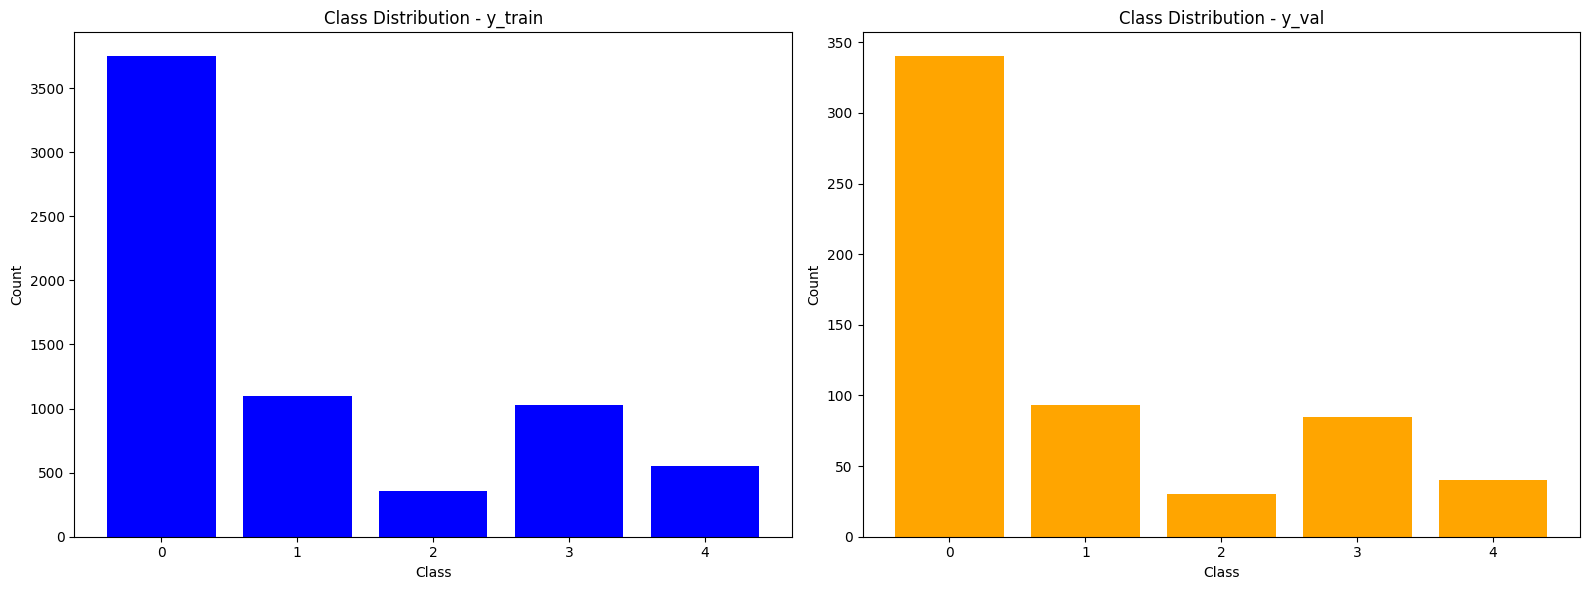

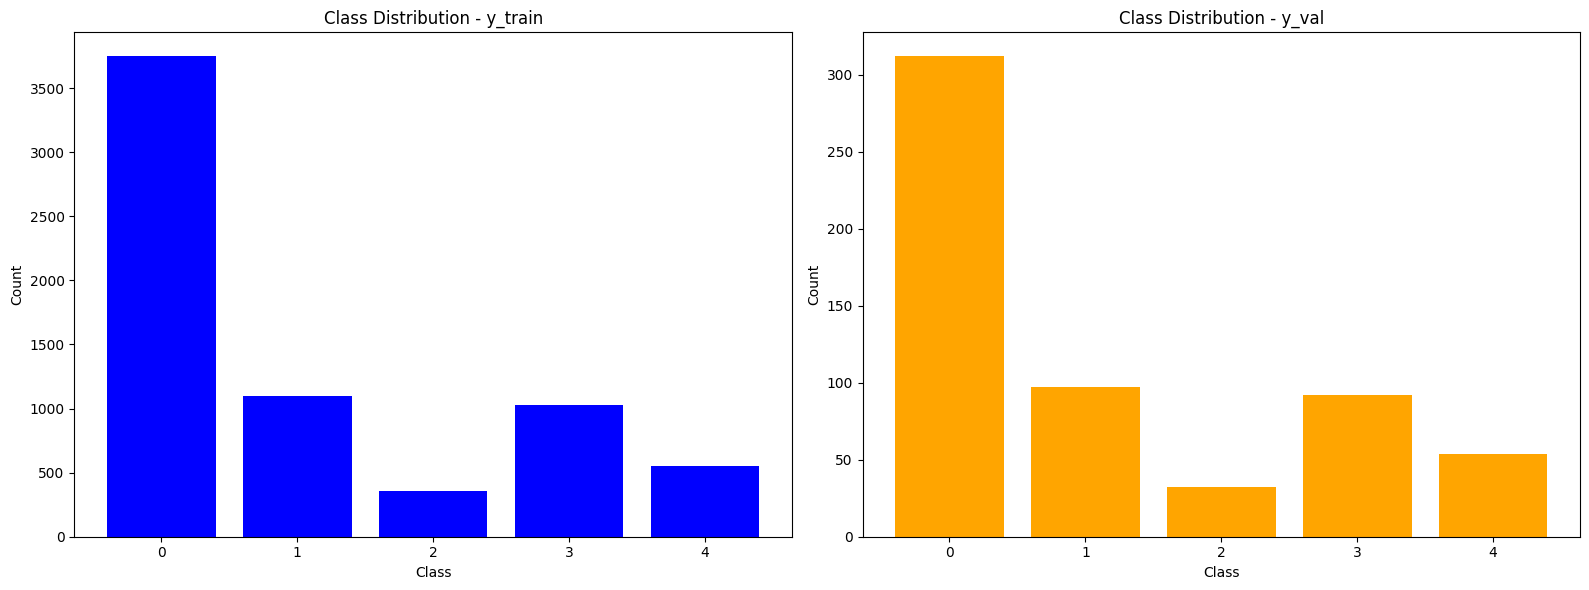

In [23]:
from sklearn.model_selection import train_test_split
from keras.utils import pad_sequences

data = pickle.load(open('train.pkl', 'rb'))
data = pd.DataFrame(data, columns=['sequence', 'composer'])
max_len = data['sequence'].apply(len).max()

X = pad_sequences(data['sequence'].tolist(), padding='post', maxlen=max_len)
y = np.array(data['composer'].tolist())

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, stratify=y_val)

train = pd.DataFrame({'sequence': X_train.tolist(), 'composer': y_train})
val = pd.DataFrame({'sequence': X_val.tolist(), 'composer': y_val})
test = pd.DataFrame({'sequence': X_test.tolist(), 'composer': y_test})

train, val = train_test_split(data, test_size=0.4, random_state=42, stratify=data['composer'])
val, test = train_test_split(val, test_size=0.5)
train = augument_pipeline(train)
train = train[train['sequence'].apply(len) > 0]
train = feature_pipeline(train)
val = feature_pipeline(val)
test = feature_pipeline(test)
train = train[~train.isna().any(axis=1)]
val = val[~val.isna().any(axis=1)]
test = test[~test.isna().any(axis=1)]
train = train[train['sequence'].apply(len) > 0]

train['sequence'] = train['sequence'].apply(lambda x: np.pad(x, (0, max_len - len(x)), 'constant', constant_values=-1))
val['sequence'] = val['sequence'].apply(lambda x: np.pad(x, (0, max_len - len(x)), 'constant', constant_values=-1))
test['sequence'] = test['sequence'].apply(lambda x: np.pad(x, (0, max_len - len(x)), 'constant', constant_values=-1))
display(train)
def plot_class_histograms(y_train, y_val):
    # Ustawienie unikalnych wartości klas
    classes = sorted(set(y_train))

    # Liczenie wystąpień klas w zbiorach y_train i y_val
    train_counts = [np.sum(y_train == class_label) for class_label in classes]
    val_counts = [np.sum(y_val == class_label) for class_label in classes]

    # Utworzenie subplots
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    # Generowanie histogramów dla y_train
    axs[0].bar(classes, train_counts, color='blue')
    axs[0].set_title('Class Distribution - y_train')
    axs[0].set_xlabel('Class')
    axs[0].set_ylabel('Count')

    # Generowanie histogramów dla y_val
    axs[1].bar(classes, val_counts, color='orange')
    axs[1].set_title('Class Distribution - y_val')
    axs[1].set_xlabel('Class')
    axs[1].set_ylabel('Count')

    # Wyświetlenie histogramów
    plt.tight_layout()
    plt.show()

plot_class_histograms(train['composer'], val['composer'])

plot_class_histograms(train['composer'], test['composer'])


In [26]:


train_dataset = FeatureDataset(train)
val_dataset = FeatureDataset(val)
test_dataset = FeatureDataset(test)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=pad_collate_feat)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=pad_collate_feat)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=pad_collate_feat)

## Eksperymenty na hiperparametrach

In [ ]:
def objective(trial):
    hidden_sizes = [16, 32, 64]
    n_layers = trial.suggest_int('n_layers', 1, 3)
    hidden_layers = trial.suggest_int('hidden_layers', 1, 3)
    hidden_size = trial.suggest_categorical('hidden_size', hidden_sizes)
    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    lr = trial.suggest_float('lr', 1e-5, 1e-3)
    bidirectional = trial.suggest_categorical('bidirectional', [True, False])
    model = LSTMRegressorFeatures(input_size=1, hidden_size=hidden_size, num_layers=n_layers, dropout=dropout, bidirectional=bidirectional, num_features=6, max_length=max_len, out_size=5, hidden_layers=hidden_layers)
    model = model.to(device)
    class_counts = torch.bincount(torch.tensor(train['composer'].values, dtype=torch.long))
    class_weights = 1 / class_counts.float()
    class_weights.to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    criterion = criterion.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    try:
      _, _, _ = train_lstm_features(model, train_loader, val_loader, optimizer, criterion, get_accuracy_features, n_epochs=10, verbose=False, device=device)
      return get_accuracy_features(model, test_loader, device)
    except:
      return 0

In [ ]:
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(n_startup_trials=5))
study.optimize(objective, n_trials=30, timeout=3600, n_jobs=1)

best_params = study.best_params
for key, value in best_params.items():
    print(f"{key}: {value}")

[I 2024-05-26 22:47:05,277] A new study created in memory with name: no-name-55164789-5c69-4203-a344-90ba661bc52a
/home/bruno/OneDrive/homework/studia/SEM4/SSNE/LAB/projekty/.venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.20800909539898704 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
[I 2024-05-26 22:49:55,433] Trial 0 finished with value: 0.43197278911564624 and parameters: {'n_layers': 1, 'hidden_layers': 2, 'hidden_size': 16, 'dropout': 0.20800909539898704, 'lr': 0.00018165844561374346, 'bidirectional': True}. Best is trial 0 with value: 0.43197278911564624.
/home/bruno/OneDrive/homework/studia/SEM4/SSNE/LAB/projekty/.venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects n

n_layers: 2
hidden_layers: 3
hidden_size: 64
dropout: 0.4174262352852624
lr: 0.0006275080621337554
bidirectional: True


/tmp/ipykernel_396643/2496925414.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_param_importances(study)


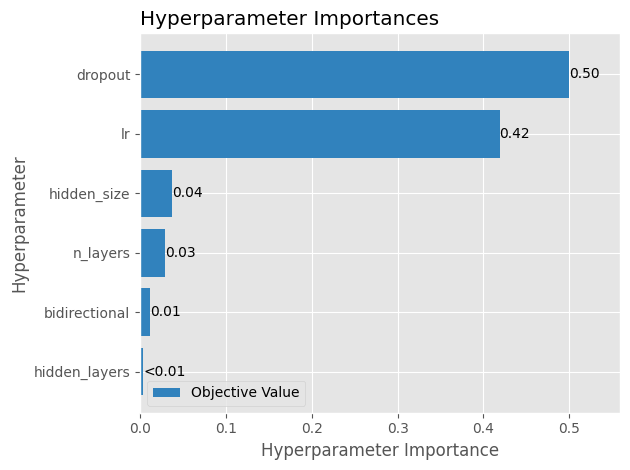

In [ ]:
fig = optuna.visualization.matplotlib.plot_param_importances(study)
plt.tight_layout()
plt.show()

/tmp/ipykernel_396643/2297176039.py:1: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_contour(study)
[W 2024-05-26 23:51:16,063] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


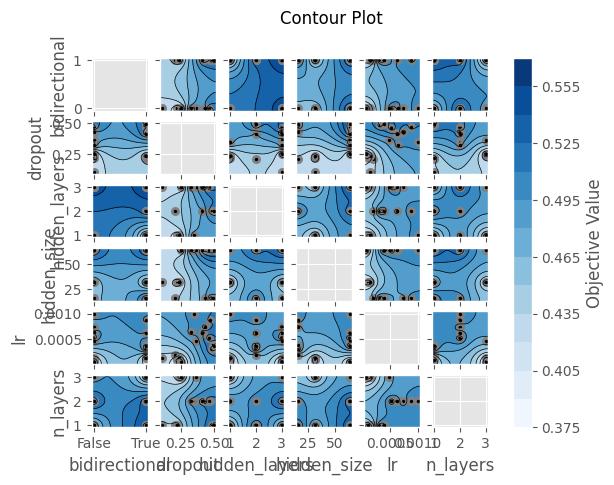

In [ ]:
fig = optuna.visualization.matplotlib.plot_contour(study)
plt.show()

## Finałowy model

In [ ]:
dropout = 0.4
hidden_size = 64
n_layers = 2
hidden_layers = 3
lr = 0.0006
bidirectional = True

model = LSTMRegressorFeatures(input_size=1, hidden_size=hidden_size, num_layers=n_layers, dropout=dropout, bidirectional=bidirectional, num_features=6, max_length=max_len, out_size=5, hidden_layers=hidden_layers)
model = model.to(device)
class_counts = torch.bincount(torch.tensor(train['composer'].values, dtype=torch.long))
class_weights = 1 / class_counts.float()
class_weights.to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_hist, train_acc, val_acc = train_lstm_features(model, train_loader, val_loader, optimizer, criterion, get_accuracy_features, n_epochs=100, device=device)
final_accuracy = get_accuracy_features(model, test_loader, device)
print(f"Final accuracy: {final_accuracy}")

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0, loss: 0.825


 10%|█         | 10/100 [05:33<50:14, 33.50s/it]

Epoch: 10, loss: 0.11


 20%|██        | 20/100 [11:09<44:54, 33.68s/it]

Epoch: 20, loss: 0.00544


 30%|███       | 30/100 [16:45<39:13, 33.62s/it]

Epoch: 30, loss: 0.00447


 40%|████      | 40/100 [22:27<34:23, 34.39s/it]

Epoch: 40, loss: 0.000108


 50%|█████     | 50/100 [28:13<28:48, 34.57s/it]

Epoch: 50, loss: 0.00956


 60%|██████    | 60/100 [33:58<23:01, 34.53s/it]

Epoch: 60, loss: 0.00362


 70%|███████   | 70/100 [39:45<17:19, 34.63s/it]

Epoch: 70, loss: 0.000211


 80%|████████  | 80/100 [45:31<11:31, 34.59s/it]

Epoch: 80, loss: 0.716


 90%|█████████ | 90/100 [51:18<05:47, 34.73s/it]

Epoch: 90, loss: 0.000213


100%|██████████| 100/100 [57:05<00:00, 34.25s/it]


Final accuracy: 0.6207482993197279


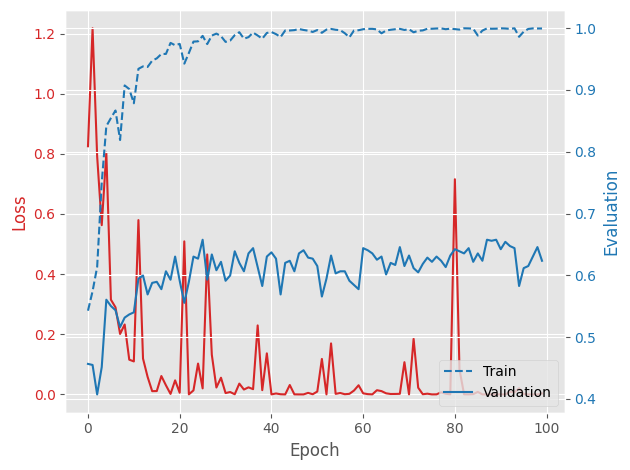

In [ ]:
plot_training(loss_hist, train_acc, val_acc)

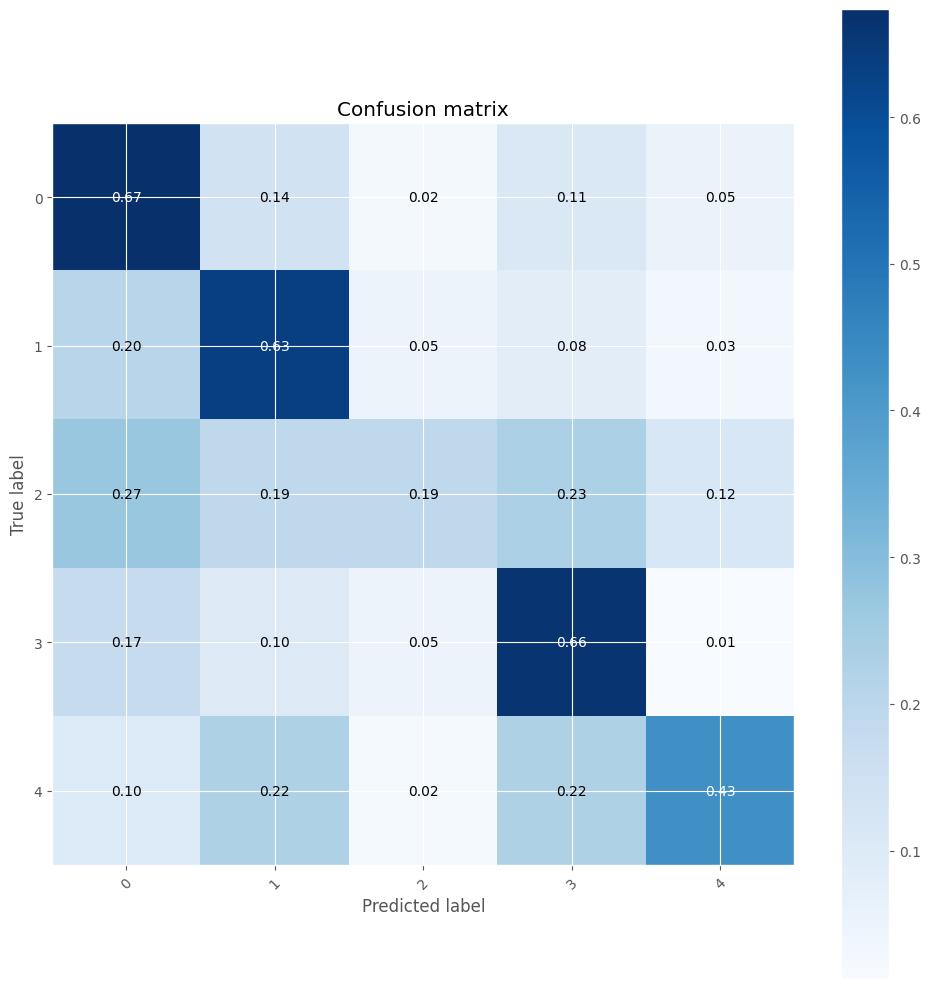

In [ ]:
classes = {0: 'bach', 1: 'beethoven', 2: 'debussy', 3: 'scarlatti', 4: 'victoria'}
cm = get_confusion_matrix_features(model, val_loader, 5, device)
plot_confusion_matrix(cm, classes)

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Embedding
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
import pickle
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
# Ścieżki do plików w Google Drive
train_path = 'train.pkl'
test_path = 'test_no_target.pkl'
#/content/drive/MyDrive/p5
# Wczytanie danych treningowych
with open(train_path, 'rb') as f:
    train_data = pickle.load(f)

# Wczytanie danych testowych
with open(test_path, 'rb') as f:
    test_data = pickle.load(f)

# Sprawdzenie załadowanych danych
print(f"Train data: {len(train_data)} samples")
print(f"Test data: {len(test_data)} samples")
X_ODP=test_data
max_length = max(len(seq) for seq in X_ODP)
X_ODP= pad_sequences(X_ODP, maxlen=max_length, padding='post')
X_ODP-=X_ODP.min()
X_ODP=X_ODP/X_ODP.max()
X_ODP_tens=torch.tensor(X_ODP,dtype=torch.float32)
X_ODP_dataset=TensorDataset(X_ODP_tens, X_ODP_tens[:,0])
odp_loader=DataLoader(X_ODP_dataset, batch_size=32)

# Predykcje na danych testowych


Train data: 2939 samples
Test data: 1103 samples


In [ ]:
model.eval()
all_predictions = []
with torch.no_grad():
    for X_batch,y_batch in odp_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        X_batch = X_batch.unsqueeze(2)  # Dodanie wymiaru wejściowego
        X_batch.to(device)

        hidden, state = model.init_hidden(X_batch.size(0))
        hidden, state = hidden.to(device), state.to(device)

        outputs, hidden = model(X_batch, (hidden, state))
        predicted_labels = torch.argmax(outputs, dim=1).cpu().numpy()
        all_predictions.extend(predicted_labels)

# Przypisanie predykcji do kompozytorów
predicted_composers = [composers[label] for label in all_predictions]

print(val_accuracy)
print(predicted_composers)
plot_class_histograms(all_predictions, all_predictions)

import pandas as pd

preds = pd.Series(all_predictions)
preds.to_csv("./piątek_bogiel_sienkiewicz.csv", header=False, index=False)

## Model bez cech

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Embedding
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
import pickle
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [5]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class VariableLenDataset(Dataset):
    def __init__(self, in_data, target):
        self.data = [(x, y) for x, y in zip(in_data, target)]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        in_data, target = self.data[idx]
        return in_data, target
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

pad = 0

def pad_collate(batch, pad_value=0):
    xx, yy = zip(*batch)
    x_lens = [len(x) for x in xx]
    y_lens = [len(y) for y in yy]

    xx_pad = pad_sequence(xx, batch_first=True, padding_value=pad_value)
    yy_pad = pad_sequence(yy, batch_first=True, padding_value=pad_value)

    return xx_pad, yy_pad, x_lens, y_lens

In [6]:
# Mapowanie kompozytorów
composers = {0: 'bach', 1: 'beethoven', 2: 'debussy', 3: 'scarlatti', 4: 'victoria'}

# Przygotowanie danych
X_train = [seq for seq, label in train_data]
y_train = [label for seq, label in train_data]

print (y_train)
# Ustal maksymalną długość sekwencji
max_length = max(len(seq) for seq in X_train)

# Wypełnienie sekwencji do tej samej długości
X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
X_test = pad_sequences(test_data, maxlen=max_length, padding='post')
print (X_train)

#print (X_train) Konwersja etykiet do tablicy NumPy
y_train = np.array(y_train)

# Sprawdzenie zakresu wartości w danych wejściowych
print(f"Min value in X_train: {X_train.min()}")
print(f"Max value in X_train: {X_train.max()}")
print(f"Min value in X_test: {X_test.min()}")
print(f"Max value in X_test: {X_test.max()}")

# Naprawa danych wejściowych, jeśli są wartości poza zakresem (opcjonalnie)
X_train -= X_train.min()
X_train=X_train/(X_train.max())

print(f"Min value in X_train: {X_train.min()}")
print(f"Max value in X_train: {X_train.max()}")
# Podział danych treningowych na zbiór walidacyjny
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)



[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [7]:


# Zakładając, że X_train, X_val, y_train, y_val są już przygotowane
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # long dla cross-entropy loss
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Tworzenie DataLoader
test1_dataset = TensorDataset(X_test_tensor, y_test_tensor)
# Tworzenie DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

test1_loader = DataLoader(test1_dataset, batch_size=32, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)



In [8]:
class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, out_size, bidirectional=False):
        super(LSTMRegressor, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = 2 if bidirectional else 1

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, bidirectional=bidirectional, dropout=0.4)
        self.fc = nn.Linear(hidden_size * self.bidirectional * max_length, out_size)

    def init_hidden(self, batch_size):
        # Inicjalizacja stanów ukrytych
        hidden = torch.zeros(self.num_layers * self.bidirectional, batch_size, self.hidden_size)
        state = torch.zeros(self.num_layers * self.bidirectional, batch_size, self.hidden_size)
        return hidden, state

    def forward(self, x, hidden):
        x = x.transpose(0, 1)
        all_outputs, hidden = self.lstm(x, hidden)
        all_outputs = all_outputs.transpose(0, 1)
        out = all_outputs.contiguous().view(all_outputs.size(0), -1)
        x = self.fc(out)
        return x, hidden

# Parametry modelu
input_size = 1  # Zmienna zależna od kształtu twoich danych
hidden_size = 5
num_layers = 2
out_size = 5  # Liczba kompozytorów

# Tworzenie modelu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMRegressor(input_size, hidden_size, num_layers, out_size, bidirectional=False).to(device)


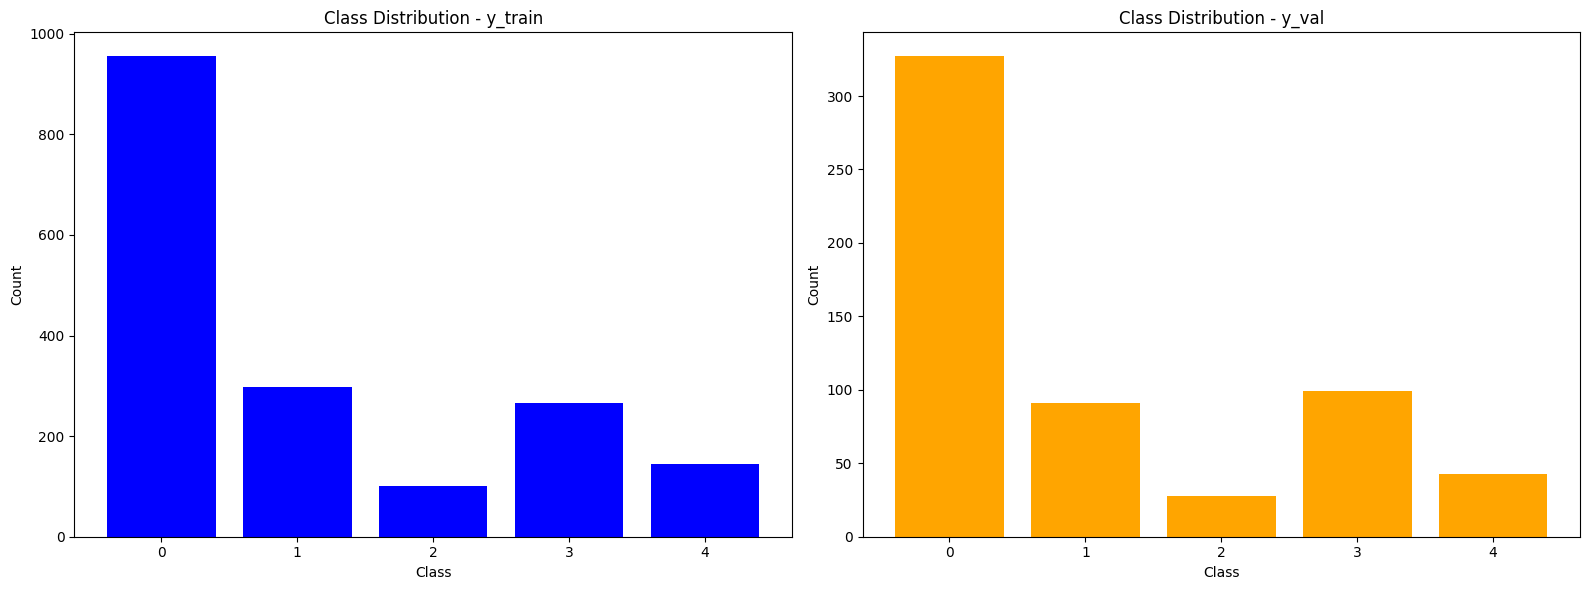

In [9]:
import numpy as np

# Funkcja generująca histogramy dla zbiorów y_train i y_val
def plot_class_histograms(y_train, y_val):
    # Ustawienie unikalnych wartości klas
    classes = sorted(set(y_train))

    # Liczenie wystąpień klas w zbiorach y_train i y_val
    train_counts = [np.sum(y_train == class_label) for class_label in classes]
    val_counts = [np.sum(y_val == class_label) for class_label in classes]

    # Utworzenie subplots
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    # Generowanie histogramów dla y_train
    axs[0].bar(classes, train_counts, color='blue')
    axs[0].set_title('Class Distribution - y_train')
    axs[0].set_xlabel('Class')
    axs[0].set_ylabel('Count')

    # Generowanie histogramów dla y_val
    axs[1].bar(classes, val_counts, color='orange')
    axs[1].set_title('Class Distribution - y_val')
    axs[1].set_xlabel('Class')
    axs[1].set_ylabel('Count')

    # Wyświetlenie histogramów
    plt.tight_layout()
    plt.show()

plot_class_histograms(y_train, y_val)

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Funkcja generująca macierz pomyłek dla zbioru trenującego
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix - Training Set')
    plt.show()

import torch
from torch.utils.data import DataLoader

# Obliczanie wag klas

from sklearn.metrics import confusion_matrix

# Funkcja generująca macierz pomyłek dla danych walidacyjnych
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix - Validation Set')
    plt.show()




Epoch 1/60, Loss: 0.807425145059824, Train Accuracy: 0.6664775950085082, Val Loss: 1.887843486509825, Val Accuracy: 0.4880952380952381
Epoch 2/60, Loss: 0.8013759313949517, Train Accuracy: 0.6732841747022121, Val Loss: 1.9075748669473749, Val Accuracy: 0.4523809523809524
Epoch 3/60, Loss: 0.7752810306847095, Train Accuracy: 0.6755530346001134, Val Loss: 2.0375756746844242, Val Accuracy: 0.4744897959183674
Epoch 4/60, Loss: 0.7603440497602735, Train Accuracy: 0.6863301191151446, Val Loss: 1.998357870076832, Val Accuracy: 0.5476190476190477
Epoch 5/60, Loss: 0.7826251494032996, Train Accuracy: 0.6789563244469654, Val Loss: 2.0899440363833777, Val Accuracy: 0.4897959183673469
Epoch 6/60, Loss: 0.7556882899786744, Train Accuracy: 0.6880317640385706, Val Loss: 2.098755425528476, Val Accuracy: 0.4965986394557823
Epoch 7/60, Loss: 0.7208379033420768, Train Accuracy: 0.707884288145207, Val Loss: 2.2039074521315727, Val Accuracy: 0.5561224489795918
Epoch 8/60, Loss: 0.7392958056713853, Train Ac

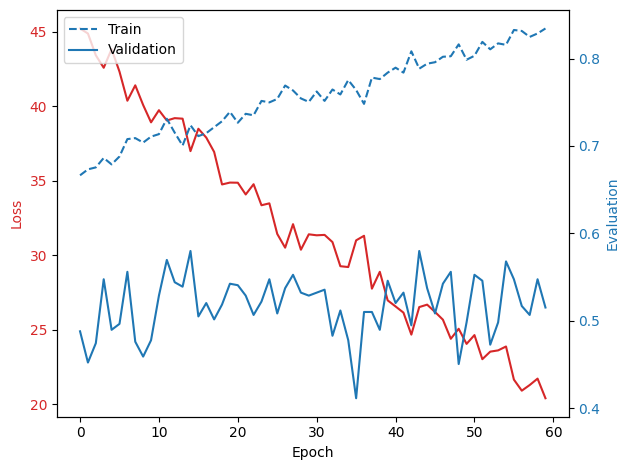

In [12]:
from sklearn.metrics import accuracy_score
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fun = nn.CrossEntropyLoss()

class_counts = torch.bincount(torch.tensor(y_train))
class_weights = 1 / class_counts.float()
class_weights.to(device)
class_weights.to(device)
class_weights = class_weights.to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Funkcja trenowania modelu z obliczaniem dokładności
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    model.train()
    loss_hist=[]
    train_eval_hist=[]
    val_eval_hist=[]
    for epoch in range(num_epochs):
        epoch_loss = 0
        all_preds = []
        all_labels = []

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            X_batch = X_batch.unsqueeze(2)  # Dodanie wymiaru wejściowego
            X_batch.to(device)
            # Inicjalizacja stanów ukrytych
            hidden, state = model.init_hidden(X_batch.size(0))
            hidden, state = hidden.to(device), state.to(device)

            # Forward pass


            outputs, hidden = model(X_batch, (hidden, state))

            loss = criterion(outputs, y_batch)

            # Backward pass i optymalizacja
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            # Zbieranie predykcji i etykiet dla obliczenia dokładności
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

        # Obliczanie dokładności dla danych treningowych
        train_accuracy = accuracy_score(all_labels, all_preds)
        # Obliczanie macierzy pomyłek dla danych walidacyjnych


        # Walidacja modelu na zbiorze walidacyjnym
        model.eval()
        val_loss = 0
        val_preds = []
        val_labels = []
        loss_hist.append(epoch_loss)
        train_eval_hist.append(train_accuracy)

        with torch.no_grad():
            for X_val_batch, y_val_batch in val_loader:
                X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
                X_val_batch = X_val_batch.unsqueeze(2)  # Dodanie wymiaru wejściowego

                # Inicjalizacja stanów ukrytych
                hidden, state = model.init_hidden(X_val_batch.size(0))
                hidden, state = hidden.to(device), state.to(device)

                # Forward pass
                outputs, hidden = model(X_val_batch, (hidden, state))
                loss = criterion(outputs, y_val_batch)
                val_loss += loss.item()

                # Zbieranie predykcji i etykiet dla obliczenia dokładności
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(y_val_batch.cpu().numpy())

        # Obliczanie dokładności dla danych walidacyjnych
        val_accuracy = accuracy_score(val_labels, val_preds)
        val_eval_hist.append(val_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader)}, '
              f'Train Accuracy: {train_accuracy}, Val Loss: {val_loss/len(val_loader)}, '
              f'Val Accuracy: {val_accuracy}')
        model.train()
    return loss_hist, train_eval_hist, val_eval_hist

# Przykładowe wywołanie funkcji trenowania
loss_hist, train_acc, val_acc =train_model(model, train_loader, val_loader,  nn.CrossEntropyLoss(weight=class_weights), optimizer, num_epochs=60)
plot_training(loss_hist, train_acc, val_acc)

## Ostatecznie model z cechami osiągnął lepszy wynik dlatego na nim zostały wygenerowane predykcje

In [30]:
# Wczytanie danych testowych
with open(test_path, 'rb') as f:
    test_data = pickle.load(f)
test = pd.DataFrame(test, columns=['sequence', 'composer'])

test['seqence'] = test['sequence'].apply(lambda x: np.pad(x, (0, max_len - len(x)), 'constant', constant_values=-1))
test = feature_pipeline(test)
test_dataset = FeatureDataset(test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=pad_collate_feat)

# Predykcje na danych testowych
model.eval()
all_predictions = []
with torch.no_grad():
    for X_batch, f_batch, y_batch, _, _, _ in test_loader:
        X_batch, f_batch, y_batch = X_batch.to(device).unsqueeze(2), f_batch.to(device), y_batch.to(device)
        hidden, state = model.init_hidden(X_batch.size(0))
        hidden, state = hidden.to(device), state.to(device)
        outputs, hidden = model(X_batch, (hidden, state), f_batch)
        predicted_labels = torch.argmax(outputs, dim=1).cpu().numpy()
        all_predictions.extend(predicted_labels)

preds = pd.Series(all_predictions)
preds.to_csv("piątek_bogiel_sienkiewicz.csv", header=False, index=False)